### Inspired by Oliver Zeigermann's Deep Learning Crash Course
This notebook can run locally (even if this is not the best idea ever), you need for that to have installed Keras. See <http://keras.io> to know how.
You also need to have installed the runtime of `jupyter notebook`.
See [here](https://github.com/OlivierLD/raspberry-coffee/blob/master/JupyterNotebooks/README.md), it is very easy.

In [38]:
import warnings
warnings.filterwarnings('ignore')

In [39]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [40]:
import pandas as pd
print(pd.__version__)

0.23.4


In [41]:
import numpy as np
print(np.__version__)

1.15.1


In [42]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.13.1


In [43]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0


In [44]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [45]:
from tensorflow import keras
print(keras.__version__)

2.2.4-tf


## Loading and exploring our data set
This is a database of customers of an insurance company. Each data point is one customer. The group represents the number of accidents the customer has been involved in in the past

* 0 - red: many accidents
* 1 - green: few or no accidents
* 2 - yellow: in the middle        

In [46]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0   106k      0 --:--:-- --:--:-- --:--:--     0-:--:-- --:--:-- --:--:--  106k


In [47]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [48]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [49]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [51]:
# we deliberately decide "group" is going to be our label, 
# it is often named lower case y
y = df['group']

In [52]:
# since 'group' is now the label we want to predict, 
# we need to remove it from the training data 
df.drop('group', axis='columns', inplace=True)

In [53]:
# input data often is named upper case X, 
# the upper case indicates, that each row is a vector
X = df.as_matrix()

In [54]:
from sklearn.model_selection import train_test_split

In [55]:
# using stratify 
# we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = \
  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [56]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1200, 3), (1200,), (300, 3), (300,))

In [57]:
# we have (almost) the same number of samples per categoery 
# in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([401, 400, 399]))

In [58]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([100, 100, 100]))

In [59]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, 
                          size=(8 ,5),
                          print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=size)

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

def plot_history(history, samples=100, init_phase_samples=None, 
                 size=(8 ,6),
                 plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=size)

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_        

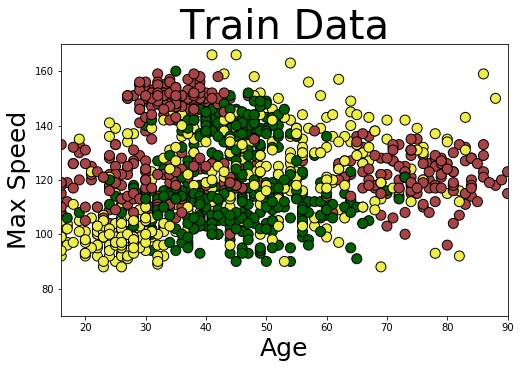

In [60]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

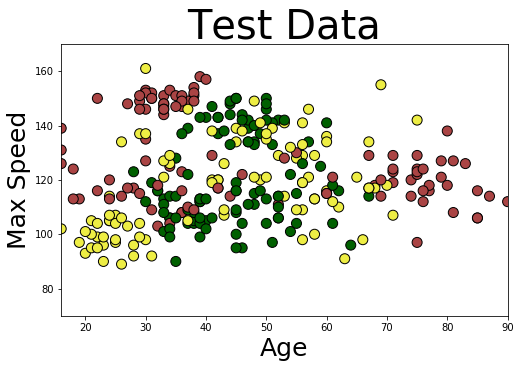

In [61]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

In [62]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

In [63]:
model = keras.Sequential()

In [64]:
from tensorflow.keras.layers import Dense

model.add(Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [65]:
num_categories = 3
model.add(Dense(num_categories, name='softmax', activation='softmax'))

In [70]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


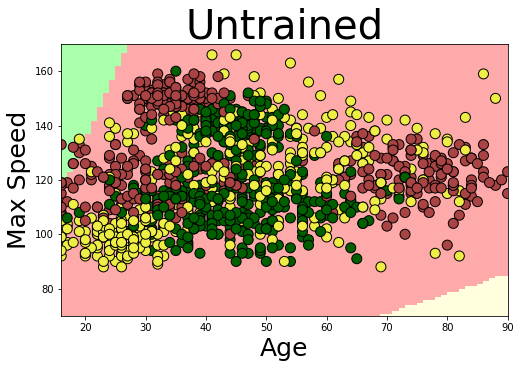

In [71]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Untrained")

In [72]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [73]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

In [74]:
BATCH_SIZE=1000
EPOCHS = 5000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, \
                          epochs=EPOCHS, batch_size=BATCH_SIZE, \
                          validation_split=0.2, verbose=0)

CPU times: user 7min 24s, sys: 26.2 s, total: 7min 51s
Wall time: 3min 39s


In [75]:
train_loss, train_accuracy = \
  model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

1200/1200 [==============================] - 0s 16us/sample - loss: 0.5171 - acc: 0.7850


0.785

In [76]:
test_loss, test_accuracy = \
  model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

300/300 [==============================] - 0s 17us/sample - loss: 0.8678 - acc: 0.6633


0.66333336

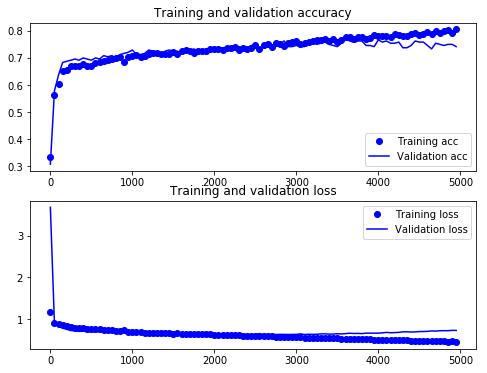

In [77]:
plot_history(history)

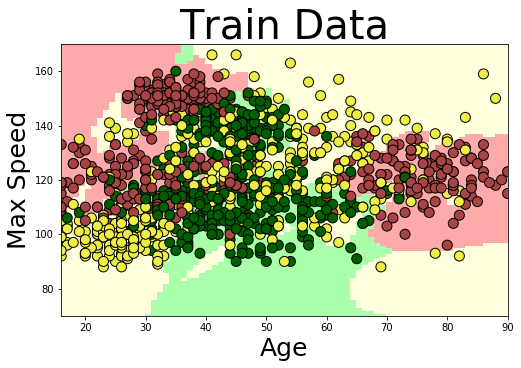

In [78]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

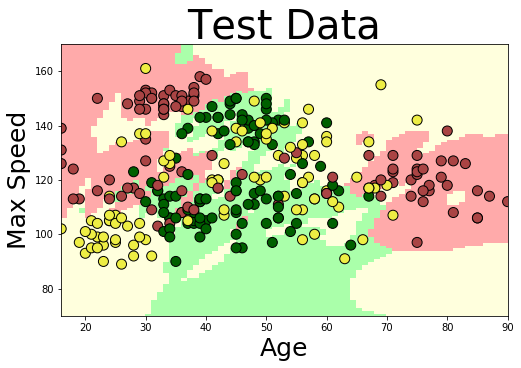

In [79]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")